In [44]:
from math import exp

H1 = -(1/2)*log(1/2,2) -(1/2)*log(1/2,2)
H2 = -(1/4)*log(1/4,2) -(3/4)*log(3/4,2)

H1, H2

(1.0, 0.8112781244591328, 1.0)

# 1) 엔트로피 계산하기

In [0]:
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    
    labels = ['no surfacing', 'flippers']
    
    return dataSet, labels

In [0]:
from math import log

def calcShannonEnt(dataSet):
  numEntries = len(dataSet)
  labelCounts = {}
  for featVec in dataSet:
    currentLabel = featVec[-1]
    if (currentLabel not in labelCounts): labelCounts[currentLabel] = 0
      
    labelCounts[currentLabel] += 1

  shannonEnt = 0.0
  for key in labelCounts:
      prob = float(labelCounts[key])/numEntries
      shannonEnt -= prob * log(prob, 2)
  
  return shannonEnt

In [0]:
myDat, labels = createDataSet()

In [4]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [5]:
labels

['no surfacing', 'flippers']

In [6]:
calcShannonEnt(myDat)

0.9709505944546686

In [8]:
myDat[0][-1] = 'maybe'

calcShannonEnt(myDat)

1.3709505944546687

# 2) 데이터셋 분할하기

In [0]:
def splitDataSet(dataSet, axis, value):
  retDataSet = []
  
  for featVec in dataSet: # row
    if featVec[axis] == value: # column
      reducedFeatVec = featVec[:axis]
      reducedFeatVec.extend(featVec[axis+1:])
      
      retDataSet.append(reducedFeatVec)
  
  return retDataSet

In [10]:
a = [1,2,3]
b = [4,5,6]
a.append(b)
print(a)

a = [1,2,3]
b = [4,5,6]
a.extend(b)
print(a)

[1, 2, 3, [4, 5, 6]]
[1, 2, 3, 4, 5, 6]


In [11]:
myDat, labels = createDataSet()
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [12]:
splitDataSet(myDat, axis=0, value=1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [13]:
splitDataSet(myDat, axis=0, value=0)

[[1, 'no'], [1, 'no']]

In [0]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
   
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0; bestFeature = -1

    for i in range(numFeatures):
      featList = [example[i] for example in dataSet]
      uniqueVals = set(featList)

      newEntropy = 0.0
      for value in uniqueVals:
        subDataSet = splitDataSet(dataSet, i, value)
        prob = len(subDataSet)/float(len(dataSet))
        newEntropy += prob * calcShannonEnt(subDataSet)
      
      infoGain = baseEntropy - newEntropy
      
      if (infoGain > bestInfoGain):
        bestInfoGain = infoGain
        bestFeature = i
    
    return bestFeature 

In [15]:
myDat, labels = createDataSet()
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [16]:
bestFeat = chooseBestFeatureToSplit(myDat)
bestFeat

0

# ※ 분할할 속성을 모두 소진했을 때 다수결로 class label 결정하기

In [0]:
def majorityCnt(classList):
  import operator

  classCount={}
  for vote in classList:
    if vote not in classCount: classCount[vote] = 0
    classCount[vote] += 1
  
  sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
  
  return sortedClassCount[0][0]

In [22]:
classList = [0, 1, 1]
label = majorityCnt(classList)
label

1

# 3) 전체 트리 구축

In [0]:
def createTree(dataSet, labels):   
    # 종료 조건 1 - 모든 데이터가 동일한 class에 속하는 경우
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]

    # 종료 조건 2 - 분할할 속성이 모두 소진된 경우
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)

    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    
    return myTree

In [45]:
myDat, labels = createDataSet()
myTree = createTree(myDat, labels)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

# 4) 구축된 의사결정 트리로 test sample 분류하기

In [0]:
def classify(inputTree, featLabels, testVec):
    firstStr = inputTree.key()[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    
    if isinstance(valueOfFeat, dict):
      classLabel = classify(valueOfFeat, featLabels, testVec)
    else: 
      classLabel = valueOfFeat
    
    return classLabel

In [0]:
def retrieveTree(i):
    listOfTrees = [{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                   {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

In [30]:
myDat, labels = createDataSet()
labels

['no surfacing', 'flippers']

In [28]:
myTree = retrieveTree(0)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [31]:
testSample = [1,0]
classify(myTree, labels, testSample)

'no'

In [32]:
testSample = [1,1]
classify(myTree, labels, testSample)

'yes'

# ※ 트리 파일로 저장하고 불러오기

In [0]:
def storeTree(inputTree, filename):
    import pickle
    fw = open(filename, 'wb')
    pickle.dump(inputTree, fw)
    fw.close()

def grabTree(filename):
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)

In [0]:
storeTree(myTree, 'myClassifier.txt')

In [37]:
grabTree('myClassifier.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

# ※ 트리 시각화하기

In [0]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree)[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else: numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree)[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else: thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree)[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            plotTree(secondDict[key], cntrPt, str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

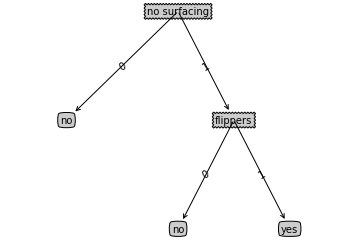

In [34]:
myTree = retrieveTree(0)
createPlot(myTree)